## About this notebook
We have seen much implementation of BERT and its varients (XLM RoBERTa , RoBERTa).So this leads me to try and experiment with other Language models .In this notebook i will try to provide a very concise use of GPT-2 model. You can change the model type from **Large , Xtralarge , Medium , DistilGPT-2**.
So lets move.Also this note book is blatant copy of **xhlulu**'s kernel. so if you want to ***UPVOTE*** this kernel than be sure to ***UPVOTE*** his notebook too.

![](https://miro.medium.com/max/2880/0*BJTwVt0i59PaSB2Z.png)

**THIS USE TRANSLATED DATA, AND IS TRAIN ON THE VALIDATION SET.**


### References
* Original Author: [@xhlulu](https://www.kaggle.com/xhlulu/)
* Original notebook: [Link](https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras)

<font color="red" size=3>Please UPVOTE this kernel if you like it. It motivates me to produce more quality content :) <br><br>
    Please do comment what your views are and what you understand from this.
    <br><br> Dont't forget to UPVOTE xhlulu's notebook </font>

In [3]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
#from kaggle_datasets import KaggleDatasets
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from keras.preprocessing import sequence
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

## Helper Functions

In [4]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=192):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [5]:
def gpt2_encode(texts, tokenizer, maxlen=192):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        max_length=maxlen,
    )
    pad_idx = tokenizer.convert_tokens_to_ids(['<pad>'])[0]
    enc_di['input_ids'] = sequence.pad_sequences(enc_di['input_ids'], maxlen=MAX_LEN, padding='post',value = pad_idx)
    return np.array(enc_di['input_ids'])

## TPU Configs

In [6]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


## Create fast tokenizer

## Load text data into memory

In [7]:
os.listdir('/kaggle/input')

['jigsaw-new-balanced-dataset',
 'bert-for-toxic-classfication-trained',
 'jigsaw-multilingual-toxic-test-translated',
 'jigsaw-multilingual-toxic-comment-classification']

In [10]:
!cp /kaggle/input/bert-for-toxic-classfication-trained/* .

In [11]:
AUTO = tf.data.experimental.AUTOTUNE

In [12]:
# DGCS_DS_PATHata access
GCS_DS_PATH = KaggleDatasets().get_gcs_path('jigsaw-multilingual-toxic-comment-classification')
MY_GCS_DS_PATH = KaggleDatasets().get_gcs_path('jigsaw-new-balanced-dataset')
NEW_GCS_DS_PATH = KaggleDatasets().get_gcs_path('jigsaw-multilingual-toxic-test-translated')

In [13]:
# Configuration
EPOCHS = 5
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192

In [14]:
from nltk import sent_tokenize
import re
LANGS = {
    'en': 'english',
    'it': 'italian', 
    'fr': 'french', 
    'es': 'spanish',
    'tr': 'turkish', 
    'ru': 'russian',
    'pt': 'portuguese'
}

def get_sentences(text, lang='en'):
    return sent_tokenize(text, LANGS.get(lang, 'english'))

def exclude_duplicate_sentences(text, lang='en'):
    sentences = []
    for sentence in get_sentences(text, lang):
        sentence = sentence.strip()
        if sentence not in sentences:
            sentences.append(sentence)
    return ' '.join(sentences)

def clean_text(text, lang='en'):
    text = str(text)
    text = re.sub(r'[0-9"]', '', text)
    text = re.sub(r'#[\S]+\b', '', text)
    text = re.sub(r'@[\S]+\b', '', text)
    text = re.sub(r'https?\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [15]:
MODEL = 'gpt2-medium'
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [ ]:
!git clone https://github.com/pennz/kaggle_runner k

In [20]:
!rsync -r  k/* .
!python3 -m pip install -e .

skipping non-regular file "kaggle_runner/runner_template/main.ipynb"


In [21]:
from kaggle_runner.utils.kernel_utils import get_obj_or_dump
X,y,X_valid,Y_valid,X_test = None,None,None,None,None
y = get_obj_or_dump("y.pkl", default=y)
X = get_obj_or_dump("x.pkl", default=X)


X_valid = get_obj_or_dump("xval.pkl", default=X_valid)
Y_valid = get_obj_or_dump("yval.pkl", default=Y_valid)

In [22]:
X_test =  get_obj_or_dump("xtest.pkl", default=X_test)

In [23]:
len(X), len(y)

(815775, 815775)

In [24]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=.2):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [25]:
def build_lrfn(lr_start=0.000001, lr_max=0.000004, 
               lr_min=0.0000001, lr_rampup_epochs=7, 
               lr_sustain_epochs=0, lr_exp_decay=.87):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

from tensorflow.keras.callbacks import Callback 

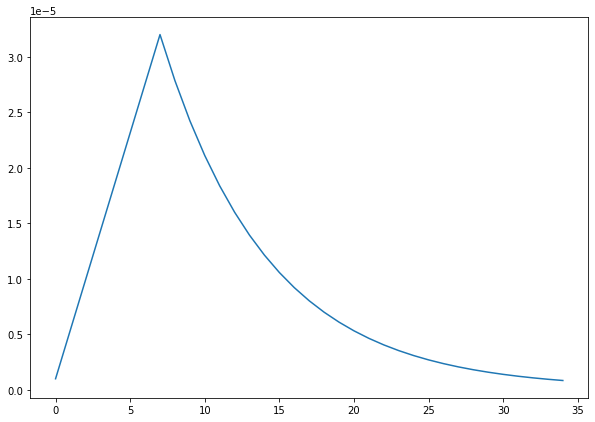

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

_lrfn = build_lrfn()
plt.plot([i for i in range(35)], [_lrfn(i) for i in range(35)]);

In [27]:
def build_model(transformer, loss , max_len=192):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-6), loss=loss, metrics=[tf.keras.metrics.AUC()])
    
    return model

In [28]:
with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, loss='binary_crossentropy', max_len=MAX_LEN)

In [ ]:
%%time
import warnings 
warnings.filterwarnings('ignore')
pred = []
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3,shuffle = True,random_state = 42)
fold = 1
for train_index, test_index in skf.split(X, y):
    X_train,a = X[train_index] , X[test_index]
    Y_train,v = y[train_index] , y[test_index]
    
    train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
    )

    valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_valid, Y_valid))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
    )
    
    test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(X_test)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
    )
    
    lrfn = build_lrfn()
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
    n_steps = X_train.shape[0] // BATCH_SIZE
    
    train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    callbacks=[lr_schedule],
    epochs=EPOCHS
    )
    sub['toxic'] = model.predict(test_dataset, verbose=1)
    sub.to_csv(str(fold) + 'gpt2m_submission.csv', index=False)
    fold = fold +1 
    print(fold)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/5
 573/4248 [===>..........................] - ETA: 20:00 - loss: 1.8756 - auc: 0.5075

# FINE

```python
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
train2.toxic = train2.toxic.round().astype(int)
train3 = pd.read_csv("/kaggle/input/jigsaw-new-balanced-dataset/new_toxic_comments.csv")
train3['toxic'] = 1
a=set(train1.columns)

b = a.intersection(train2.columns)

# Combine train1 with a subset of train2
train = pd.concat([
    train1[b],
    train2[b].query('toxic==1'),
    train2[b].query('toxic==0').sample(n=300000, random_state=42)
])
del train1
del train2

train = train.drop(columns=['id'])
train = train[['comment_text','toxic']]
train3.columns = train.columns
train = pd.concat([train,train3],axis=0)
train['comment_text']  = train.comment_text.apply(lambda x : clean_text(x))
from sklearn.utils import shuffle
train = shuffle(train).reset_index(drop=True)


X_valid =  pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv")
Y_valid = X_valid.toxic.values
X_valid = gpt2_encode(X_valid.comment_text.values, tokenizer, maxlen=MAX_LEN)

X_test = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv")
sub = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv")
X_test = gpt2_encode(X_test.content.values, tokenizer, maxlen=MAX_LEN)


X = gpt2_encode(train.comment_text.values, tokenizer, maxlen=MAX_LEN)
y = train.toxic.values
del train
import gc
gc.collect()
```